# GSE205506 Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import os as os
import seaborn as sns
from load_10X_matrices import load_10X_matrices

## 0. Loading Data

In [2]:
# Takes ~10-11 min to load
directory = '/home/data/PanCanSC/CRC/GEO/GSE205506/'
adata = load_10X_matrices('/home/data/PanCanSC/CRC/GEO/GSE205506/')
print(adata)

Loading GSM6213975_Colon_MGI_252_v3_
Loading GSM6213985_Colon_MGI_292_v3_
Loading GSM6213987_Colon_MGI_302_v3_
Loading GSM6213960_Colon_MGI_141_v2_
Loading GSM6213994_Colon_MGI_323_v3_
Loading GSM6213986_Colon_MGI_301_v3_
Loading GSM6213976_Colon_MGI_253_v3_
Loading GSM6213962_Colon_MGI_152_v3_
Loading GSM6213965_Colon_181_v2_
Loading GSM6213972_Colon_MGI_241_v3_
Loading GSM6213958_Colon_MGI_121_v3_
Loading GSM6213991_Colon_MGI_313_v3_


In [ ]:
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 324020 × 33538
    obs: 'sample_ID'>

#### Extracting sample src & patient ID from sample ID

In [ ]:
sampleID = adata.obs['sample_ID']
short = [x.split('_')[3] for x in sampleID]
adata.obs['sample_src'] = [x[-1] for x in short]
adata.obs['patient_ID'] = [x[:-1] for x in short]

AnnData object with n_obs × n_vars = 65352 × 18179
    obs: 'sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
adata.shape

(65352, 18179)

## 1. Basic Filtering

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


#### Removing cells expressing <500 || >5000 genes:

In [ ]:
# removing cells expressing <500 || >5000 genes
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=5000)

filtered out 106603 cells that have less than 500 genes expressed


/home/wad18/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 9509 cells that have more than 5000 genes expressed


#### Removing cells containing <400 || >25000 UMIs:

In [ ]:
# removing cells containing <400 || >25000 UMIs
sc.pp.filter_cells(adata, min_counts = 400)
sc.pp.filter_cells(adata, max_counts = 25000)

filtered out 7245 cells that have more than 25000 counts


/home/wad18/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Removing genes covered by <3 cells

In [ ]:
# removing genes covered by <3 cells
sc.pp.filter_genes(adata, min_cells=200)
adata.obs_names_make_unique

filtered out 15359 genes that are detected in less than 200 cells


/home/wad18/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 200663 × 18179
    obs: 'sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts'
    var: 'n_cells'>

### Annotate the group of mitochondrial genes as 'mt'

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# filtering cells surpassed 20% mito ratio mark
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

## 2. Integrating Samples

#### Normalization & Logarithmization:

In [ ]:
# Log normalization scaled up to 10000
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize adata
sc.pp.log1p(adata)

normalizing counts per cell


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:00)


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(X, out=X)
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:25)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)


In [ ]:
sc.tl.leiden(adata)
cluster_labels = adata.obs['leiden']

running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


,sample_ID,sample_src,patient_ID,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGATTGACA-1,GSM6213967_Colon_MGI_191_v3_,1,19,1959,5623.0,1959,5623.0,689.0,12.253245,1
AAACCCACATGAAGCG-1,GSM6213967_Colon_MGI_191_v3_,1,19,3149,8703.0,3144,8698.0,1301.0,14.957460,8
AAACCCAGTGATAGAT-1,GSM6213967_Colon_MGI_191_v3_,1,19,1472,3354.0,1469,3351.0,606.0,18.084154,1
AAACCCATCACGACTA-1,GSM6213967_Colon_MGI_191_v3_,1,19,1988,4175.0,1985,4172.0,154.0,3.691275,1
AAACGAAAGAGTGAAG-1,GSM6213967_Colon_MGI_191_v3_,1,19,1268,2788.0,1264,2784.0,239.0,8.584770,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGACTCGAG-1,GSM6213989_Colon_MGI_311_v3_,1,31,3497,12028.0,3492,12022.0,2196.0,18.266510,14
TTTGTTGCACATTACG-1,GSM6213989_Colon_MGI_311_v3_,1,31,3050,10016.0,3044,10009.0,1681.0,16.794884,14
TTTGTTGCATGAGGGT-1,GSM6213989_Colon_MGI_311_v3_,1,31,2965,8202.0,2961,8198.0,768.0,9.368138,14
TTTGTTGTCATTGCCC-1,GSM6213989_Colon_MGI_311_v3_,1,31,3591,11220.0,3586,11215.0,2044.0,18.225592,14


In [ ]:
adata.obs.columns

Index(['sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragme

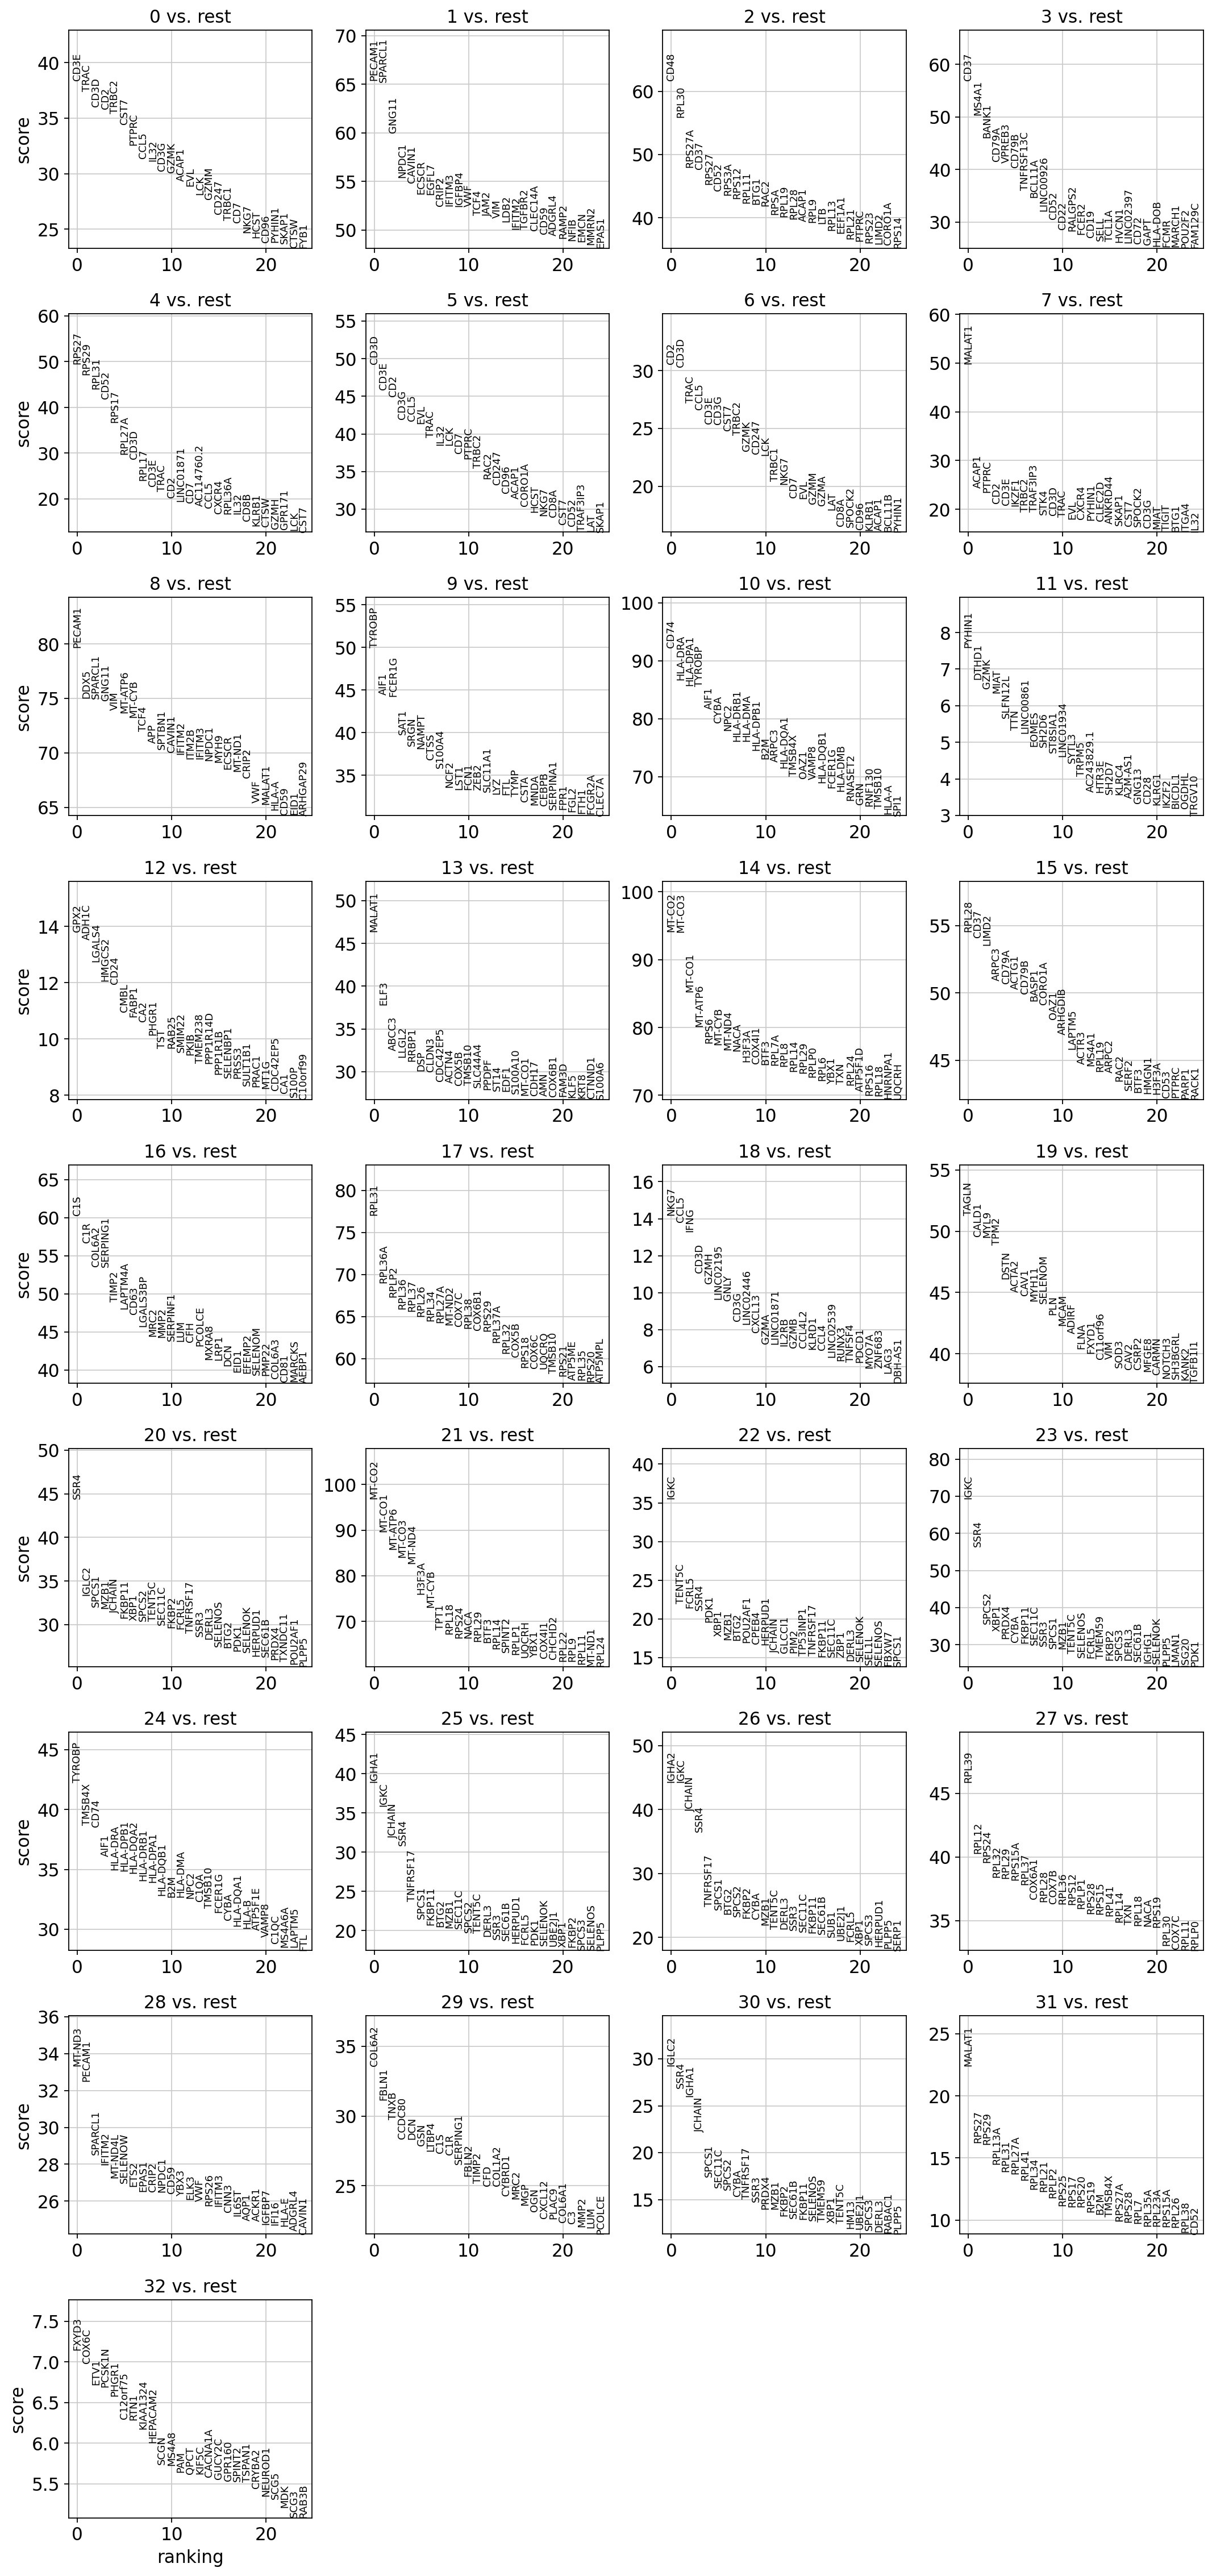

In [ ]:
# load/find cell cycle markers: T-test/T-cells
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# Scoring cells for cell cycle
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,28_n,28_p,29_n,29_p,30_n,30_p,31_n,31_p,32_n,32_p
0,CD3E,5.857174e-282,PECAM1,0.0,CD48,0.0,CD37,0.0,RPS27,0.000000e+00,...,MT-ND3,5.018846e-127,COL6A2,8.938714e-114,IGLC2,5.616126e-59,MALAT1,5.417134e-32,FXYD3,5.897954e-08
1,TRAC,5.010091e-270,SPARCL1,0.0,RPL30,0.0,MS4A1,0.0,RPS29,0.000000e+00,...,PECAM1,1.722829e-123,FBLN1,2.005306e-104,SSR4,5.548704e-55,RPS27,3.608480e-24,COX6C,9.280740e-08
2,CD3D,1.602164e-253,GNG11,0.0,RPS27A,0.0,BANK1,0.0,RPL31,0.000000e+00,...,SPARCL1,1.829406e-105,TNXB,2.687495e-99,IGHA1,2.770040e-53,RPS29,4.799838e-24,ETV1,1.922913e-07
3,CD2,1.368696e-249,NPDC1,0.0,CD37,0.0,CD79A,0.0,CD52,0.000000e+00,...,IFITM2,5.993681e-103,CCDC80,4.493779e-94,JCHAIN,4.962029e-46,RPL13A,9.531515e-22,PCSK1N,2.062385e-07
4,TRBC2,4.985615e-245,CAVIN1,0.0,RPS27,0.0,VPREB3,0.0,RPS17,5.223826e-262,...,MT-ND4L,1.712896e-99,DCN,6.633539e-94,SPCS1,8.106231e-36,RPL31,7.070518e-21,PHGR1,2.518165e-07


In [ ]:
# Scale the counts to regress out cell cycle effect
sc.pp.scale(adata, max_value=10)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
adata.obs.columns

Index(['sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

## 3. Unsupervised cell clustering & identification of major cell types

In [ ]:
# 2000 highly variable genes w/ 'vst' method?
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pp.highly_variable_genes(adata, flavor='vst', n_top_genes=2000)

NameError: name 'sc' is not defined

In [ ]:
adata.raw = adata
highly_variable_genes = adata.var['highly_variable']

# Filter out genes that aren't highly variable
adata = adata[:, highly_variable_genes]

KeyError: 'highly_variable'

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
adata.obs_names_make_unique

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)


<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 65352 × 25
    obs: 'sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'rank_genes_groups', 'leiden', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
# Identifying 30 PCs(principle components)
sc.pp.pca(adata, n_comps=30)
pcs = adata.obsm['X_pca']

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:04)


In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata)
#sc.pl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)
running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


In [ ]:
adata.obs

,sample_ID,sample_src,patient_ID,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGATTGACA-1,GSM6213967_Colon_MGI_191_v3_,1,19,1959,5623.0,1959,5623.0,689.0,12.253245,1
AAACCCACATGAAGCG-1,GSM6213967_Colon_MGI_191_v3_,1,19,3149,8703.0,3144,8698.0,1301.0,14.957460,8
AAACCCAGTGATAGAT-1,GSM6213967_Colon_MGI_191_v3_,1,19,1472,3354.0,1469,3351.0,606.0,18.084154,1
AAACCCATCACGACTA-1,GSM6213967_Colon_MGI_191_v3_,1,19,1988,4175.0,1985,4172.0,154.0,3.691275,1
AAACGAAAGAGTGAAG-1,GSM6213967_Colon_MGI_191_v3_,1,19,1268,2788.0,1264,2784.0,239.0,8.584770,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGACTCGAG-1,GSM6213989_Colon_MGI_311_v3_,1,31,3497,12028.0,3492,12022.0,2196.0,18.266510,14
TTTGTTGCACATTACG-1,GSM6213989_Colon_MGI_311_v3_,1,31,3050,10016.0,3044,10009.0,1681.0,16.794884,14
TTTGTTGCATGAGGGT-1,GSM6213989_Colon_MGI_311_v3_,1,31,2965,8202.0,2961,8198.0,768.0,9.368138,14
TTTGTTGTCATTGCCC-1,GSM6213989_Colon_MGI_311_v3_,1,31,3591,11220.0,3586,11215.0,2044.0,18.225592,14


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


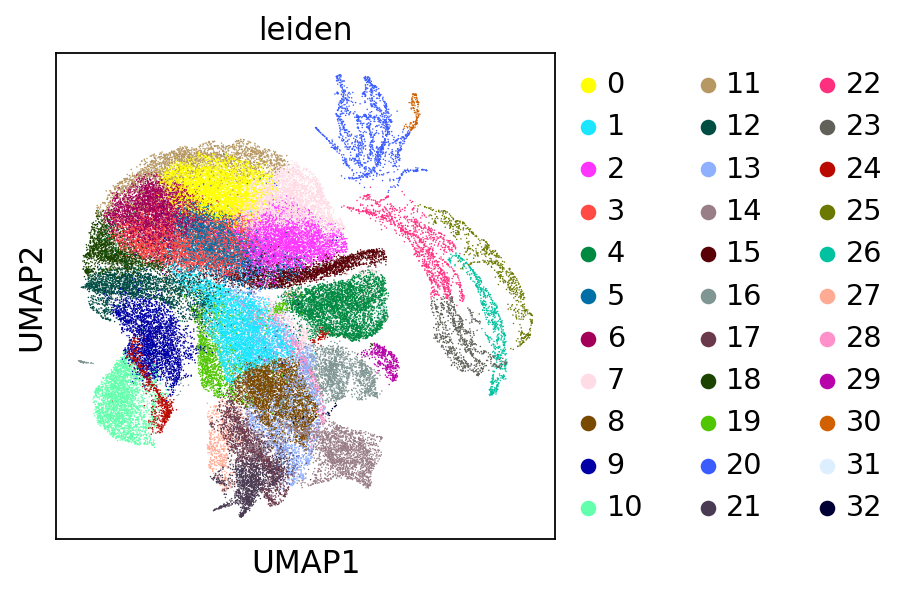

In [ ]:
sc.pl.umap(adata, color='leiden')